# Train

In [1]:
from app.core.training.data import CreateLoader
from transformers import (
    VisionEncoderDecoderModel,
    ViTModel,
    BertLMHeadModel,
    AutoTokenizer,
    TrOCRProcessor,
)
import os

In [3]:
processor = TrOCRProcessor.from_pretrained(
    pretrained_model_name_or_path="app/core/models/trocr-base-printed",
    tokenizer = AutoTokenizer.from_pretrained("app/core/models/bert-fa-base-uncased"),
    use_fast=True,
    device="cuda",
)
# tokenizer = AutoTokenizer.from_pretrained("app/core/models/bert-fa-base-uncased")
encoder = ViTModel.from_pretrained("app/core/models/trocr-base-printed")
decoder = BertLMHeadModel.from_pretrained(
    "app/core/models/bert-fa-base-uncased",
    is_decoder=True,
    add_cross_attention = True,
)
model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder).to("cuda")
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.generation_config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.bos_token_id = processor.tokenizer.cls_token_id
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

Some weights of ViTModel were not initialized from the model checkpoint at app/core/models/trocr-base-printed and are newly initialized: ['embeddings.cls_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'encoder.layer.0.layernorm_after.weight', 'encoder.layer.0.layernorm_before.bias', 'encoder.layer.0.layernorm_before.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.attention.attention.key.weight', 'encoder.layer.1.attention.attention.query.weight', 'encoder.layer.1.attention

In [4]:
root = "app/core/datasets/Persian-OCR-Dataset-kaggle-farboodi"
train_root = os.path.join(root, "train")
valid_root = os.path.join(root, "valid")
test_root = os.path.join(root, "test")

In [5]:
train_data, train_loader = CreateLoader(
    root_dir=train_root,
    processor=processor,
    device="cuda",
)(batch_size=16, shuffle=True)
valid_data, valid_loader = CreateLoader(
    root_dir=valid_root,
    processor=processor,
    device="cuda",
)(batch_size=16, shuffle=True)
test_data, test_loader = CreateLoader(
    root_dir=test_root,
    processor=processor,
    device="cuda",
)(batch_size=16, shuffle=True)

In [6]:
a, b = train_loader.__iter__().__next__()

In [16]:
import torch
from torch.optim import AdamW
from transformers import get_scheduler
import matplotlib.pyplot as plt

In [12]:
num_train_steps = 100 * len(train_loader)

In [31]:
model_params = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
optimizer = AdamW(model_params, lr=2e-5)

# scheduler
num_training_steps = int(num_train_steps * 0.9)
num_warmup_steps = num_train_steps - int(num_train_steps * 0.9)
scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# track LR
lrs = []
for step in range(num_training_steps):
    optimizer.step()   # fake step
    scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])

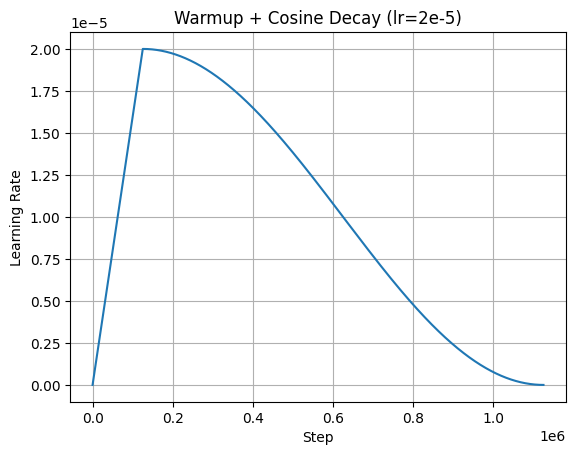

In [32]:
plt.plot(lrs)
plt.grid()
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Warmup + Cosine Decay (lr=2e-5)")
plt.show()

# Dev

In [45]:
from transformers import (
    VisionEncoderDecoderModel,
    ViTModel,
    BertLMHeadModel,
    AutoTokenizer,
    TrOCRProcessor,
    ViTImageProcessor,
    EncoderDecoderModel,
    BertConfig
)
import torch
from PIL import Image
from torchinfo import summary
import numpy as np

In [46]:
processor = TrOCRProcessor.from_pretrained(
    pretrained_model_name_or_path="app/core/models/trocr-base-printed",
    tokenizer = AutoTokenizer.from_pretrained("app/core/models/bert-fa-base-uncased"),
    use_fast=True,
    device="cuda",
)
# tokenizer = AutoTokenizer.from_pretrained("app/core/models/bert-fa-base-uncased")
encoder = ViTModel.from_pretrained("app/core/models/trocr-base-printed")
decoder = BertLMHeadModel.from_pretrained(
    "app/core/models/bert-fa-base-uncased",
    is_decoder=True,
    add_cross_attention = True,
)
model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder).to("cuda")
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.generation_config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.bos_token_id = processor.tokenizer.cls_token_id
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

Some weights of ViTModel were not initialized from the model checkpoint at app/core/models/trocr-base-printed and are newly initialized: ['embeddings.cls_token', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'embeddings.position_embeddings', 'encoder.layer.0.attention.attention.key.weight', 'encoder.layer.0.attention.attention.query.weight', 'encoder.layer.0.attention.attention.value.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'encoder.layer.0.layernorm_after.weight', 'encoder.layer.0.layernorm_before.bias', 'encoder.layer.0.layernorm_before.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.attention.attention.key.weight', 'encoder.layer.1.attention.attention.query.weight', 'encoder.layer.1.attention

In [47]:
width, height = 384, 384
dummy_image = Image.fromarray(np.uint8(np.random.rand(height, width, 3) * 255))

In [49]:
pixel_values = processor(images=[dummy_image, dummy_image], return_tensors="pt", device="cuda").pixel_values
pixel_values.shape

torch.Size([2, 3, 384, 384])

In [51]:
generated_ids = model.generate(pixel_values.to("cuda"))
processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

/home/al-fazli/projects/cfavit-ocr/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
`cache.key_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].keys` instead.
`cache.value_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].values` instead.


'دی دی دی دی دی دی دی دی دی دی دی دی دی دی دی دی دی دی دی دی'

In [52]:
text = ["احمد محسن", "سلام علیکم و رحمه الله"]
labels = processor.tokenizer(text, return_tensors="pt", padding=True).input_ids.to("cuda")

In [53]:
processor.batch_decode(labels, skip_special_tokens=False)

['[CLS] احمد محسن [SEP] [PAD] [PAD] [PAD]',
 '[CLS] سلام علیکم و رحمه الله [SEP]']

In [54]:
labels.shape

torch.Size([2, 7])

In [55]:
a = model(pixel_values=pixel_values.to("cuda"), labels=labels)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [56]:
a.loss

tensor(14.2843, device='cuda:0', grad_fn=<NllLossBackward0>)

In [65]:
pixel_values = processor(images=[dummy_image, dummy_image, dummy_image, dummy_image], return_tensors="pt", device="cuda").pixel_values
text = ["احمد محسن", "احمد محسن", "احمد محسن", "احمد جواد"]
labels = processor.tokenizer(text, return_tensors="pt", padding=True).input_ids.to("cuda")

In [66]:
a = model(pixel_values=pixel_values.to("cuda"), labels=labels)
a.loss

tensor(13.7568, device='cuda:0', grad_fn=<NllLossBackward0>)

In [250]:
generated_ids

tensor([[   2, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379,
         1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379],
        [   2, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379,
         1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379]],
       device='cuda:0')

In [251]:
processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

'و و و و و و و و و و و و و و و و و و و و'

In [14]:
processor.tokenizer

RobertaTokenizerFast(name_or_path='app/core/models/trocr-base-printed', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}
)